In [110]:
# Import necessary libraries
import torch
import os
import torchvision
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure
from torchvision import models, transforms

%matplotlib inline



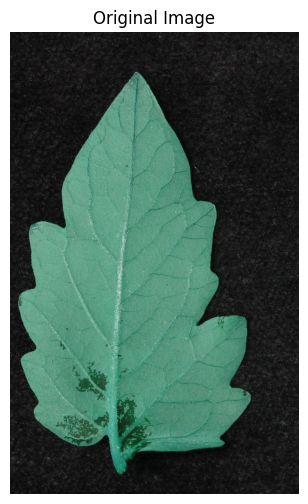

In [105]:

image_path = 'data/test/leaf02.jpg'  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [106]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the SAM model
sam_checkpoint = 'sam_vit_h_4b8939.pth'  # Download the checkpoint from the SAM repository
model_type = 'vit_h'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

In [121]:
def preprocess_image(image_path, mask_generator):
    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    masks = mask_generator.generate(image_rgb)
    largest_mask = max(masks, key=lambda x: x['area'])
    segmentation_mask = largest_mask['segmentation']
    mask = segmentation_mask.astype(np.uint8)

    if np.mean(image_rgb[mask == 1]) < np.mean(image_rgb[mask == 0]):
        mask = 1 - mask  # Invert the mask

    leaf_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    leaf_gray = cv2.cvtColor(leaf_only, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_enhanced = clahe.apply(leaf_gray)

    gray_norm = gray_enhanced / 255.0

    filtered = filters.frangi(gray_norm)

    thresh = filters.threshold_otsu(filtered)
    binary = filtered > thresh
    cleaned = morphology.remove_small_objects(binary, min_size=0)

    # Fill small holes
    #cleaned = morphology.remove_small_holes(cleaned, area_threshold=500)

    # Display the cleaned image
    plt.figure(figsize=(8, 8))
    plt.imshow(cleaned, cmap='gray')
    plt.title('Cleaned Binary Image')
    plt.axis('off')
    plt.show()

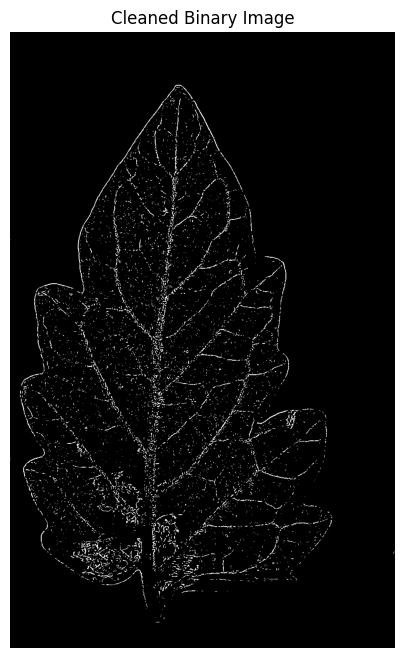

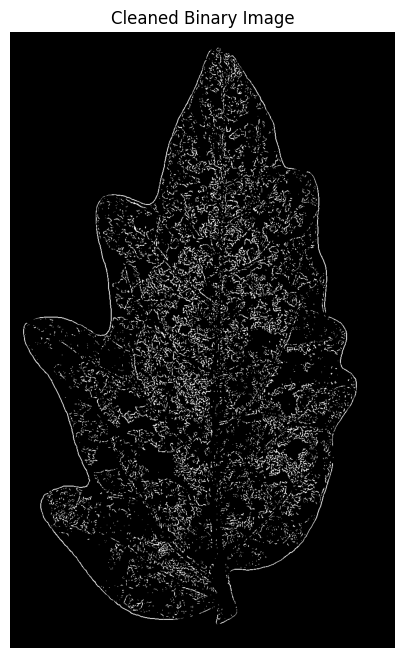

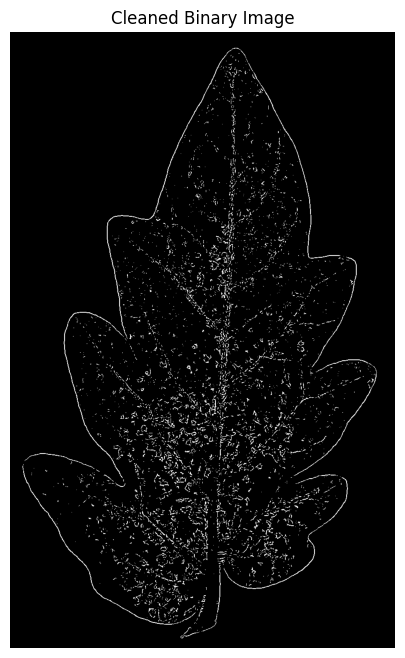

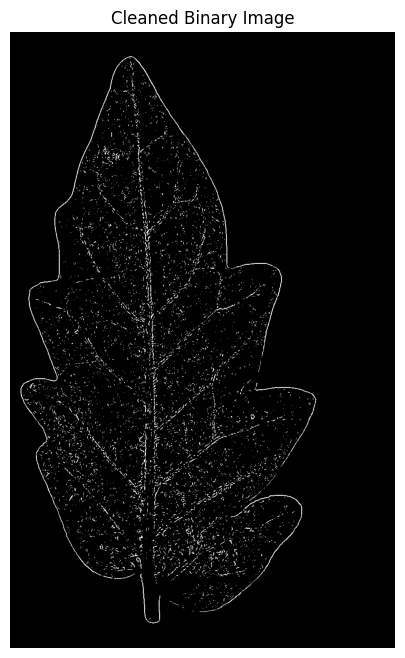

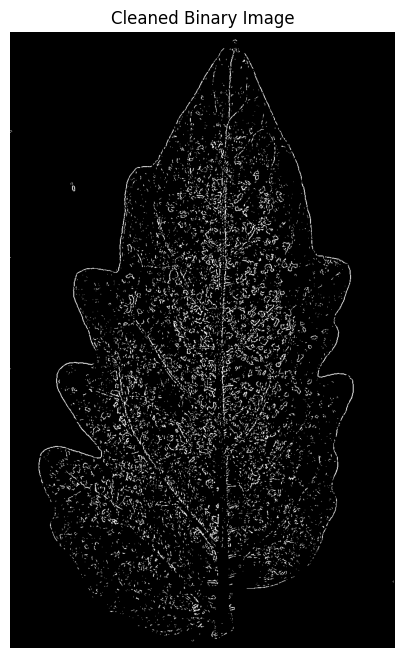

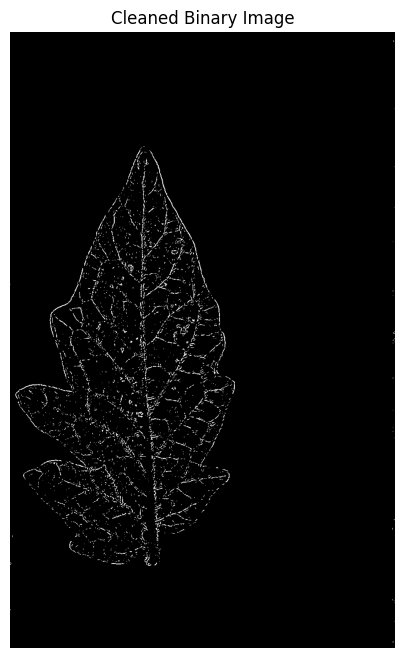

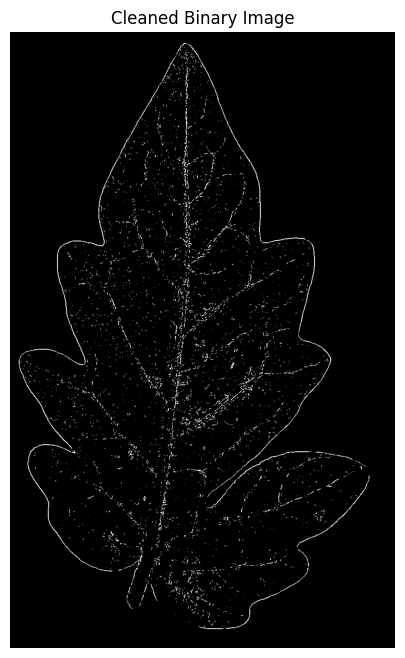

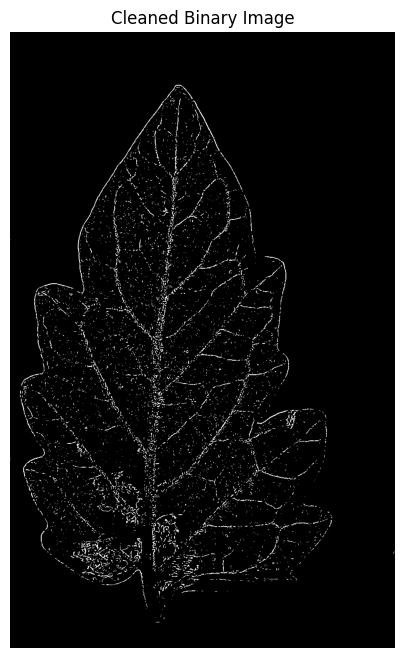

KeyboardInterrupt: 

In [123]:
for image in os.listdir('data/test'):
    preprocess_image('data/test/' + image, mask_generator)